Advanced Lane Finding Project

The goals / steps of this project are the following:

    Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    Apply a distortion correction to raw images.
    Use color transforms, gradients, etc., to create a thresholded binary image.
    Apply a perspective transform to rectify binary image ("birds-eye view").
    Detect lane pixels and fit to find the lane boundary.
    Determine the curvature of the lane and vehicle position with respect to center.
    Warp the detected lane boundaries back onto the original image.
    Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


Camera Calibration


The code for this step is contained in the first code cell of the IPython notebook located in "./P4.ipynb" .

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:


In [20]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#matplotlib qt

def get_camera_calibration_parameter():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    img = cv2.imread('camera_cal/calibration2.jpg')
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

In [2]:
def calibrate_image(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

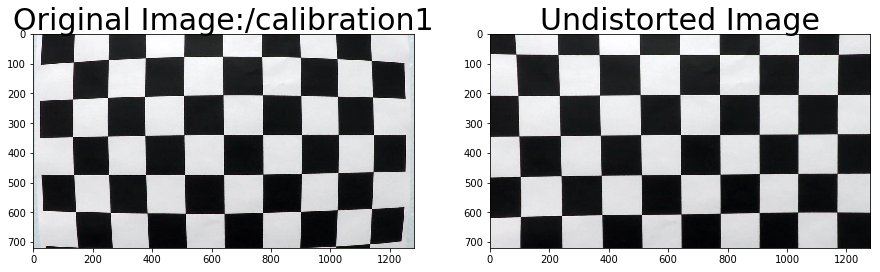

In [3]:
import os
%matplotlib inline
mtx, dist = get_camera_calibration_parameter()
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
for fname in images:
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    f = os.path.basename(fname)
    cv2.imwrite('./output_images/undistort_'+f, dst)

fname = './camera_cal/calibration1.jpg'
img = cv2.imread(fname)
dst = calibrate_image(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.imshow(img)
ax1.set_title('Original Image:'+fname[-17:-4], fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

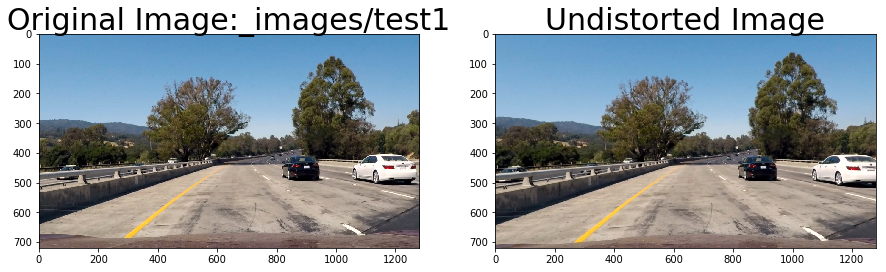

In [4]:
%matplotlib inline
# Make a list of calibration images
images = glob.glob('./test_images/*.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = calibrate_image(img_rgb, mtx, dist)
    dst = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
    f = os.path.basename(fname)
    cv2.imwrite('./output_images/undistort_'+f, dst)
    
fname = './test_images/test1.jpg'
img = cv2.imread(fname)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = calibrate_image(img_rgb, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.imshow(img_rgb)
ax1.set_title('Original Image:'+fname[-17:-4], fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

sobel to gradient detect , but I dont use those code at last.

In [5]:
# Calculate directional gradient
def abs_sobel_thresh(gray, orient='x', thresh = (0,255)):
    thresh_min=thresh[0]
    thresh_max=thresh[1]
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output
# Calculate gradient magnitude
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Calculate gradient direction
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output
def combine_img(image):
    # Choose a Sobel kernel size
    ksize = 7# Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gradx = abs_sobel_thresh(gray, orient='x', thresh=(20, 100))
    grady = abs_sobel_thresh(gray, orient='y', thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.1))
    hls_binary = hls_select(image, thresh=(90, 255))
    
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1) )|( (mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
    combined[((gradx == 1) & (grady == 1) )|( (mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

   Applies an image mask. 
   Only keeps the region of the image defined by the polygon
  formed from `vertices`. The rest of the image is set to black.

In [6]:
def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


1 We do a color threshold filter to pick only yellow and white elements, using opencv convert color to HSV space (Hue, Saturation and Value). 
2 apply Sobel filters and threshold the magnitude of the gradients in x-  for S and L channels of HLS image. We chose HLS channel because HLS colorspace was found to be most robust for detecting edges
3 get R color space and V space

In [65]:
# converting the image from RGB to HSV space and select colors
def hsv_select(img, thresh_low, thresh_high):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv = cv2.inRange(hsv, thresh_low, thresh_high)
    #rgb = cv2.cvtColor(hsv, cv2.COLOR_RGB2GRAY)
    return hsv

def yellow_white_select(img):
    yellow_hsv_low  = np.array([ 0, 80, 200])
    yellow_hsv_high = np.array([ 40, 255, 255])
    res = hsv_select(img,yellow_hsv_low,yellow_hsv_high)
    
    white_hsv_low  = np.array([  20,   0,   200])
    white_hsv_high = np.array([ 255,  80, 255])
    res2 = hsv_select(img,white_hsv_low,white_hsv_high)
    
    return (res | res2)
def l_s_select(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
  
    color_binary = np.zeros_like(sxbinary)
    color_binary[(s_binary ==1 ) | (sxbinary == 1)] = 1

    return color_binary

def v_select(img, thresh = (200, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,2]
    binary = np.zeros_like(v_channel)
    binary[(v_channel > thresh[0]) & (v_channel <= thresh[1])] = 1
    return binary


def r_select(img, thresh = (200, 255)):
    img = np.copy(img)
    
    r_channel = img[:,:,0]
    
    binary = np.zeros_like(r_channel)
    binary[(r_channel > thresh[0]) & (r_channel <= thresh[1])] = 1
    return binary

use srcoure and destination to get perspective transform matrix: 
    src = np.float32([[585, 450], [203, 720], [1127, 720], [695, 450]])
    dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])
us matrix to perspective to bird view

In [8]:

#Perspective transfomation
def get_perspective_transform():
    src = np.float32([[585, 450], [203, 720], [1127, 720], [695, 450]])
    dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def bird_view_perspective(image, M):
    img_size = (image.shape[1], image.shape[0])
    binary_warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return binary_warped



Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/family/anaconda2/envs/carnd-term1/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/family/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/home/family/anaconda2/envs/carnd-term1/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



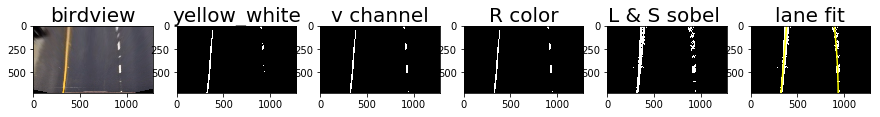

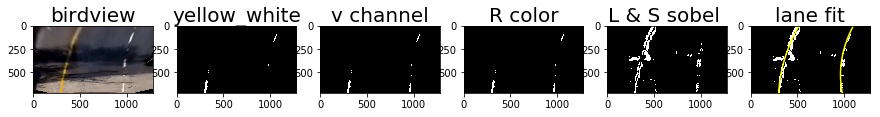

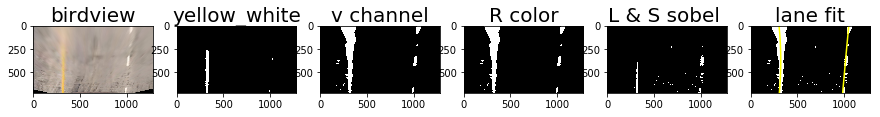

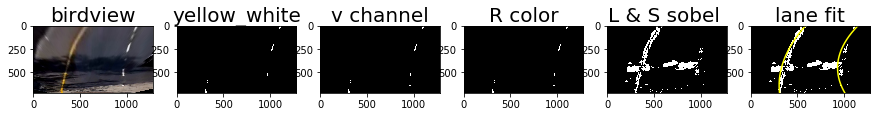

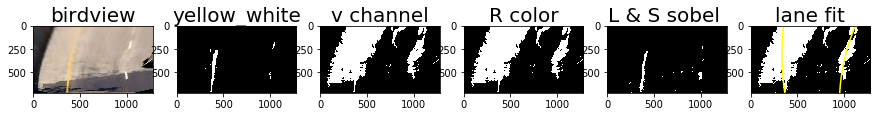

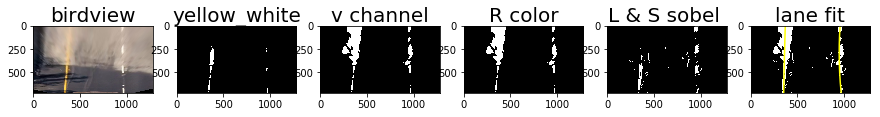

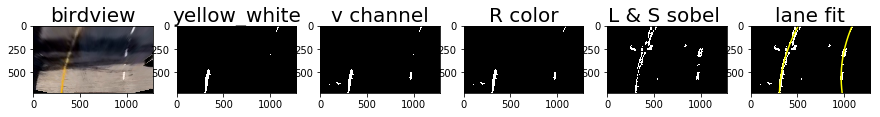

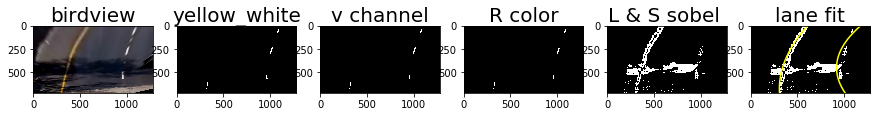

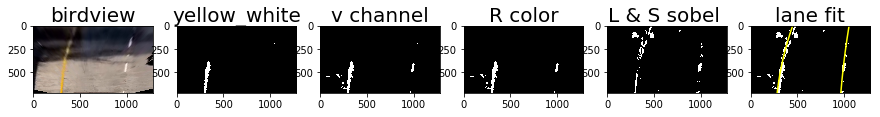

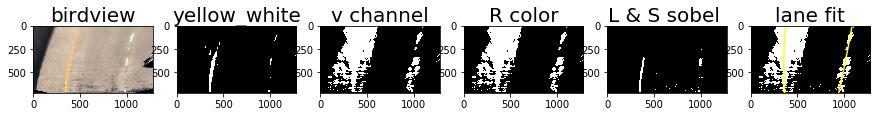

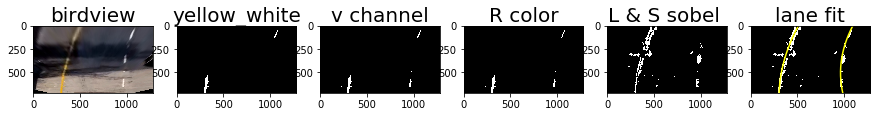

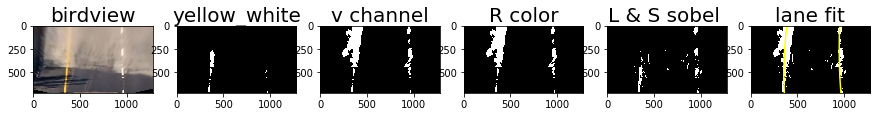

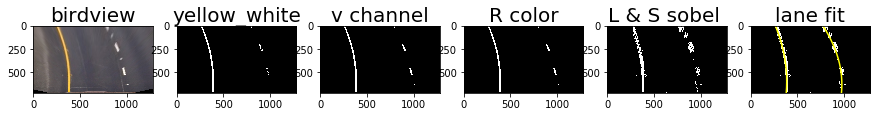

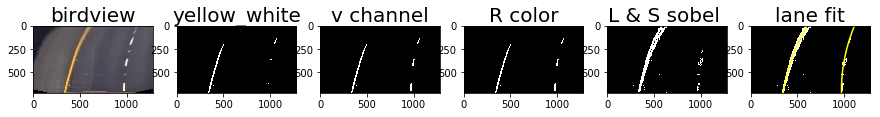

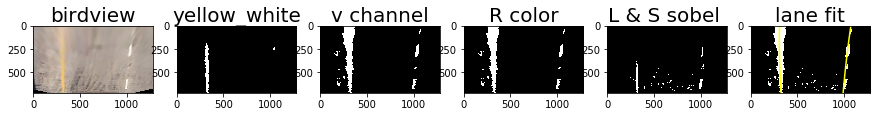

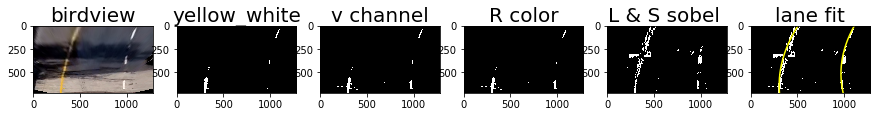

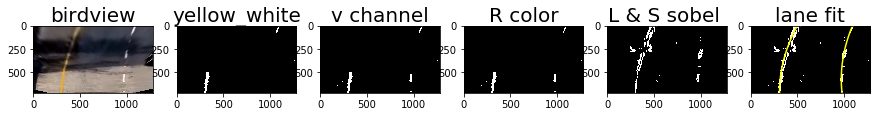

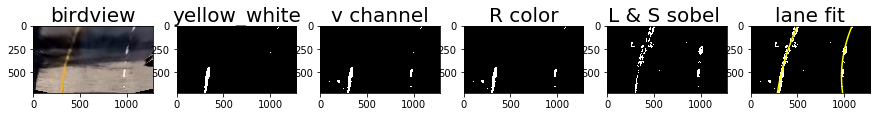

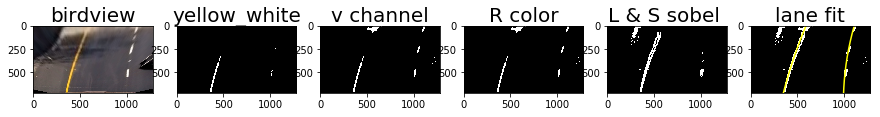

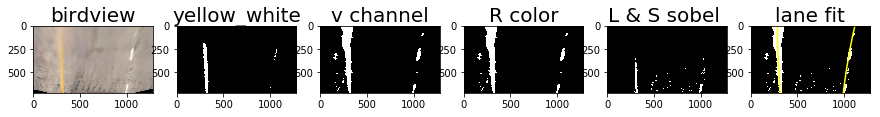

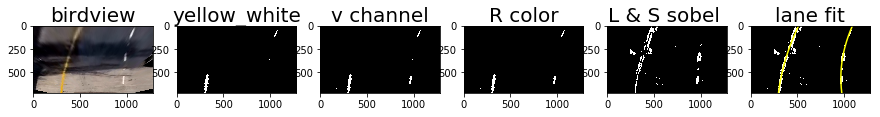

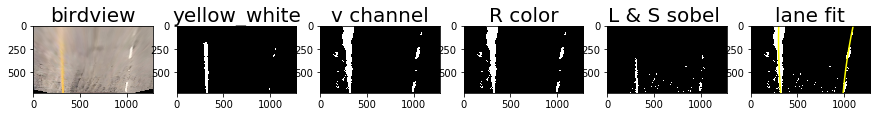

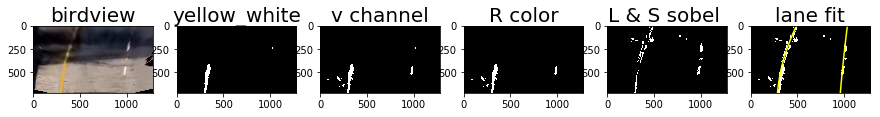

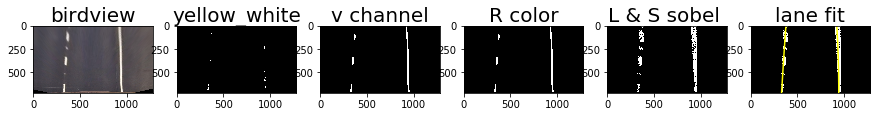

In [66]:
M, Minv = get_perspective_transform()
# Make a list of calibration images
images = glob.glob('./test_images/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = calibrate_image(img_rgb, mtx, dist)
    
    birdview = bird_view_perspective(dst, M)
    yellow_white = yellow_white_select(birdview)
    vchannel = v_select(birdview)
    rchannel = r_select(birdview)
    
    
    combined = l_s_select(dst)
    imshape = combined.shape
    vertices = np.array([[[0,imshape[0]], [np.int32(imshape[1]/2)-60,450], [np.int32(imshape[1]/2)+60,450], [imshape[1],imshape[0]]]], np.int32)
    region = region_of_interest(combined,vertices )
    ls = bird_view_perspective(region, M)
    
    last = np.zeros_like(yellow_white)
    last[(vchannel ==1 ) | (rchannel == 1) | (ls == 1)] = 1
    
    
    left_fit, right_fit = lane_fit(last)
    
    ploty = np.linspace(0, last.shape[0]-1, last.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    
    f, (ax1, ax2, ax3, ax4,ax5, ax6) = plt.subplots(1, 6, figsize=(15,8))
    ax1.imshow(birdview)
    ax1.set_title('birdview', fontsize=20)
    
    ax2.imshow(yellow_white, cmap='gray')
    ax2.set_title('yellow_white', fontsize=20)
    
    ax3.imshow(vchannel, cmap='gray')
    #ax3.plot(left_fitx, ploty, color='yellow')
    #ax3.plot(right_fitx, ploty, color='yellow')
    #ax3.set_xlim(0, 1280)
    #ax3.set_ylim(720, 0)
    #ax3.imshow(last,cmap='gray')
    ax3.set_title('v channel', fontsize=20)
    ax4.imshow(rchannel,cmap='gray')
    ax4.set_title('R color', fontsize=20)
    
    ax5.imshow(ls,cmap='gray')
    ax5.set_title('L & S sobel ', fontsize=20)
    ax6.imshow(last,cmap='gray')
    ax6.plot(left_fitx, ploty, color='yellow')
    ax6.plot(right_fitx, ploty, color='yellow')
    ax6.set_title('lane fit', fontsize=20)
    

pipeline
1 perspective to birdview
2 select V channel of HSV, R color space of RGB 
3 select edges and image mask
4 combine  images to get last image to lane detection

In [67]:
def pipeline(img, M, Minv):
    
    birdview = bird_view_perspective(img, M)
    #yellow_white = yellow_white_select(birdview)
    vchannel = v_select(birdview)
    rchannel = r_select(birdview)
    
    
    combined = l_s_select(img)
    imshape = combined.shape
    vertices = np.array([[[0,imshape[0]], [np.int32(imshape[1]/2)-60,450], [np.int32(imshape[1]/2)+60,450], [imshape[1],imshape[0]]]], np.int32)
    region = region_of_interest(combined,vertices )
    ls = bird_view_perspective(region, M)
    
    last = np.zeros_like(yellow_white)
    last[(vchannel ==1 ) | (rchannel == 1) | (ls == 1)] = 1
    
    return last, combined

In order to better estimate where the lane is, we use a histogram on the bottom half of image. Then we divide the image in windows, and for each left and right window we find the mean of it, re-centering the window.

In [43]:
def lane_fit(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
     
    return left_fit, right_fit


def continous_lane_fit(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    return left_fit, right_fit



Sanity Check
check that the detection makes sense. To confirm that your detected lane lines are real, consider:
    Checking that they have similar curvature
    Checking that they are separated by approximately the right distance horizontally
    Checking that they are roughly parallel
so I detected all the distance of every point with same y, check the mean and the variance

In [11]:
def sanity_check(left_fit, right_fit, ploty):
    #Performs a sanity check on the lanes
    #Checking that they have similar curvature
    #Checking that they are separated by approximately the right distance horizontally
    #Checking that they are roughly parallel
    xm_per_pix = 3.7/700
    left_fitx = get_curve_x(left_fit, ploty)
    right_fitx = get_curve_x(right_fit, ploty)
    distance = (right_fitx - left_fitx)*xm_per_pix
    distance_mean = np.mean(distance)
    distance_var = np.var(distance)
    if distance_mean > 3.5 or distance_mean < 2.5:
        return False
    if distance_var > 0.1:
        return False
    return True

1 calculate the radius for both lines, left and right, and the chosen point is the base of vehicle
radius = (1 + (2a y_eval+b)**2)**1.5 / abs(2a). the real world is in meters. We have to estimate the real world dimension from the photo.
2 the middle point of beginning of lines if the offset (in pixels). This value times conversion factor is the estimate of offset.
((xL(720) + xR(720))/2–1280/2 )* xm_per_pix

In [12]:
def get_curverad(leftx, rightx, ploty):

    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad

def get_car_diff(left_fit, right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    return center

def get_curve_x(fit, ploty):
    return fit[0]*ploty**2 + fit[1]*ploty + fit[2]

Once we know the position of lanes in birds-eye view, we use opencv function polyfill to draw a area in the image.
Then, we warp back to original perspective, and merge it to the color image.

In [13]:
def draw_lane_region(warped, left_fitx, right_fitx, ploty, Minv, undist):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result, color_warp

I want to  use CNN to regression six parameter for curve line. just save the data for training later. 

In [14]:
import time
import pandas as pd
#save good data to train deep learning network
def save_data(df, sep=','):
    fname = './dataset/lane_detect_data.csv'
    if not os.path.isfile(fname):
        df.to_csv(fname, index=False, sep=sep)
    else:
        df.to_csv(fname, mode='a', index=False, sep=sep, header=False)
def save_to_csv(img, left_fit, right_fit):
    now = int(1000*time.time())
    filename = './dataset/'+str(now)+'.jpg'
    img2 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(filename, img2)
    data = {'image':filename, 'leftfit0':left_fit[0],'leftfit1':left_fit[1],'leftfit2':left_fit[2],'rightfit0':right_fit[0],'rightfit1':right_fit[1],'rightfit2':right_fit[2]}
    df = pd.DataFrame(data=data, index=list(range(0,1)))
    save_data(df)
    

Test all pipeline, and display all the images.
compose the output image with some other images, to form a diagnostic panel.

left_fit = [ -6.69220202e-06  -7.82900654e-02   3.84715001e+02], right_fit = [ -7.20771986e-05   1.10925707e-01   8.94430157e+02]
mean =  2.9941627692
var =  0.0245852851778
left_curverad = 24545, right_curverad = 2278, diff = -0.05
left_fit = [  3.57435371e-04  -5.59013122e-01   5.17454046e+02], right_fit = [  5.02127774e-04  -5.27600693e-01   1.09998808e+03]
mean =  3.27068149033
var =  0.0230156600852
left_curverad = 459, right_curverad = 327, diff = 0.00
left_fit = [ -1.32219783e-04   9.99504953e-02   3.03420590e+02], right_fit = [  1.04615602e-05  -9.80029281e-02   1.05024650e+03]
mean =  3.70140414655
var =  0.0118259063285
left_curverad = 1242, right_curverad = 15701, diff = 0.03
left_fit = [  6.92578673e-04  -8.86394937e-01   5.88144485e+02], right_fit = [  1.07742563e-03  -9.72567557e-01   1.14934889e+03]
mean =  3.15339595537
var =  0.049993333521
left_curverad = 237, right_curverad = 154, diff = 0.10
left_fit = [  1.85825391e-04  -1.16078254e-01   3.52481702e+02], right_fit 

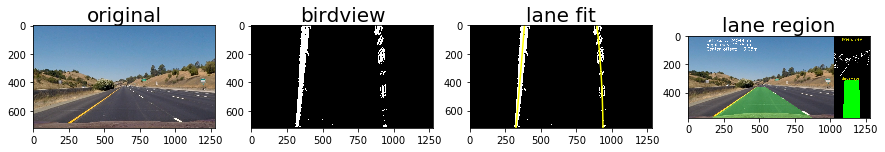

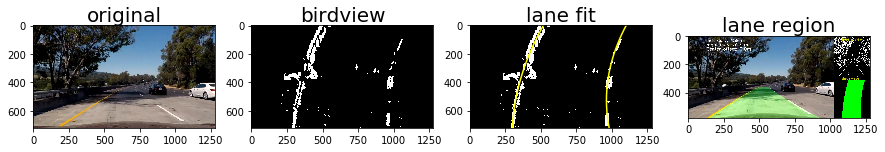

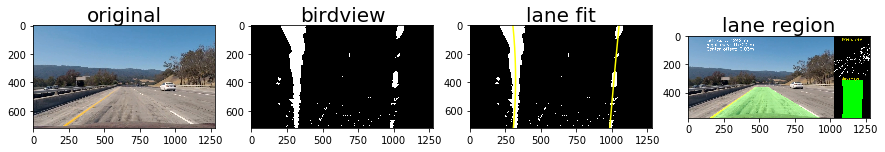

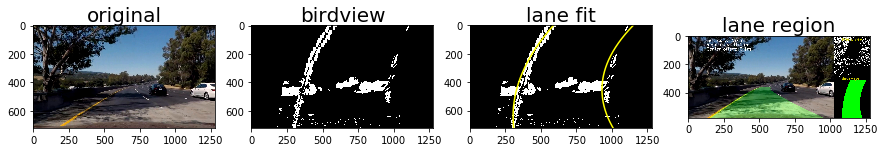

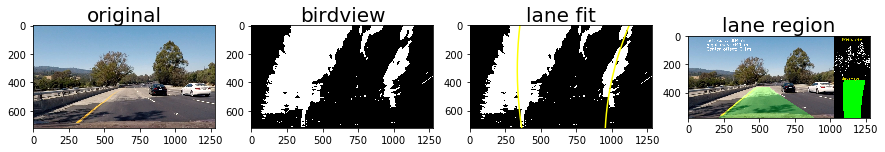

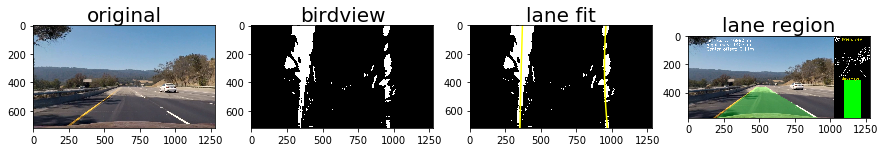

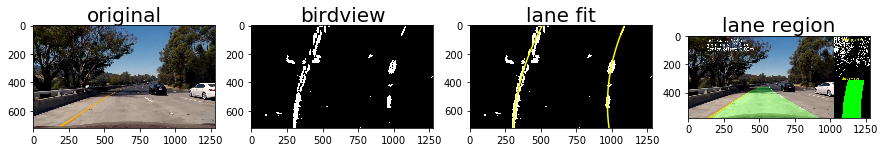

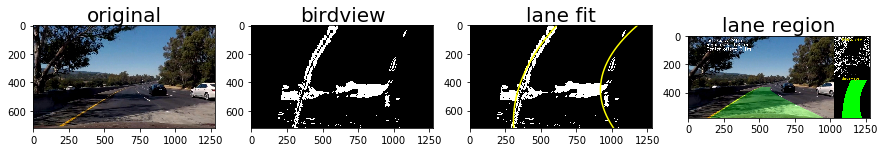

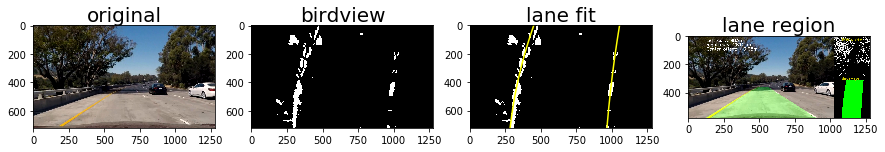

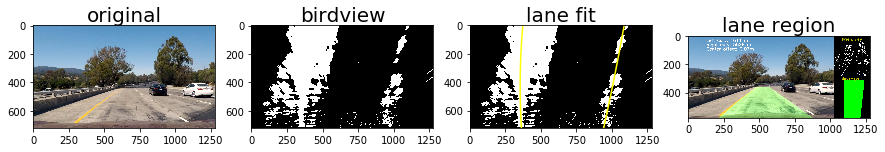

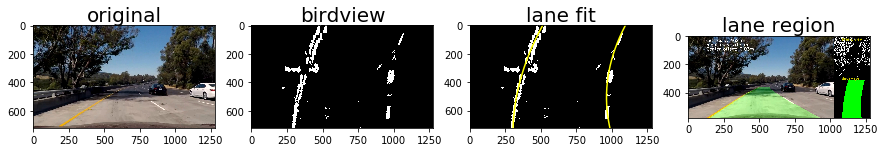

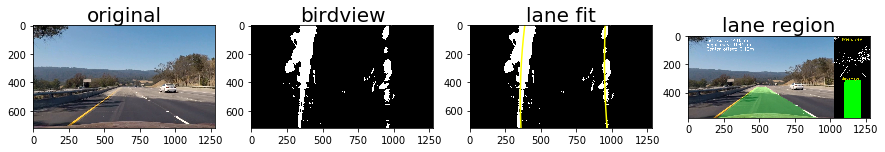

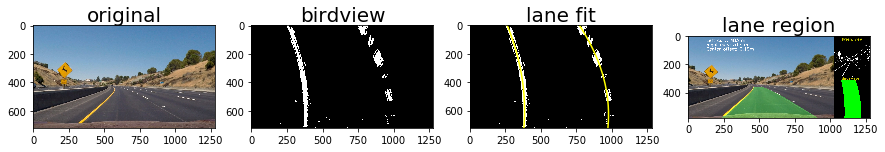

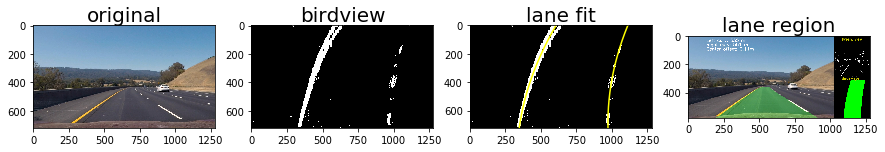

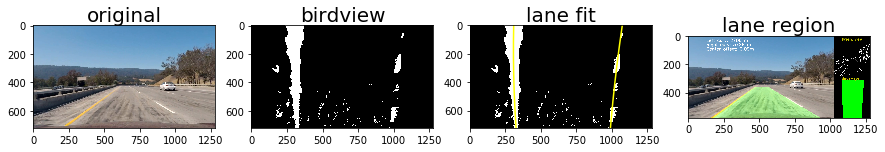

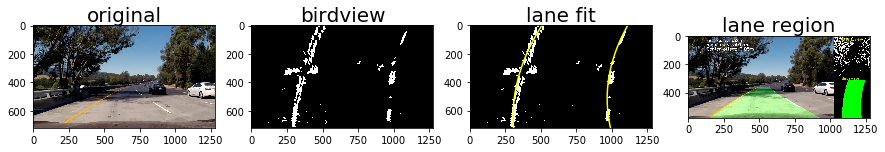

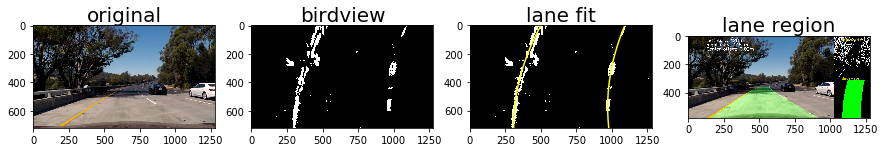

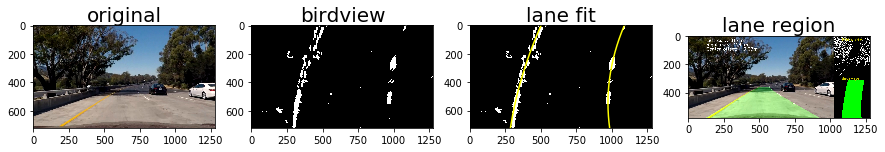

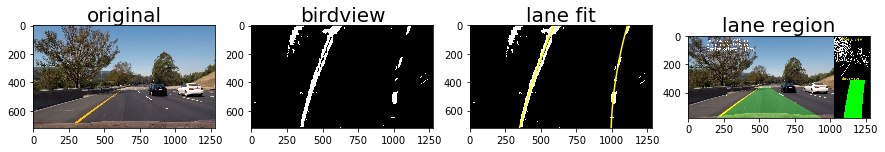

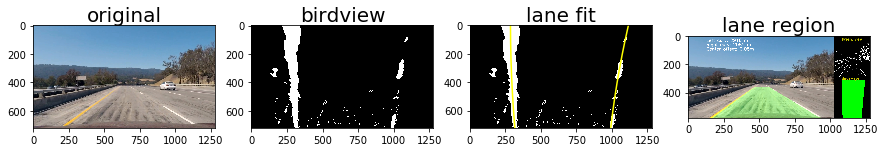

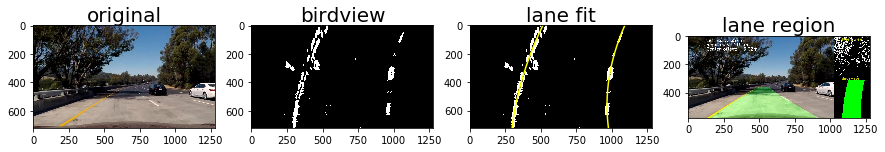

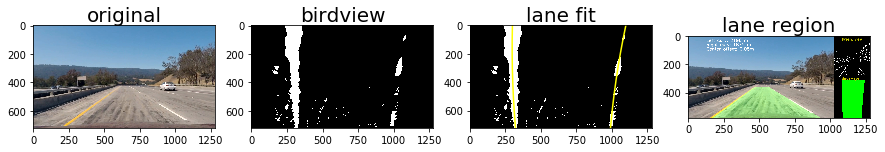

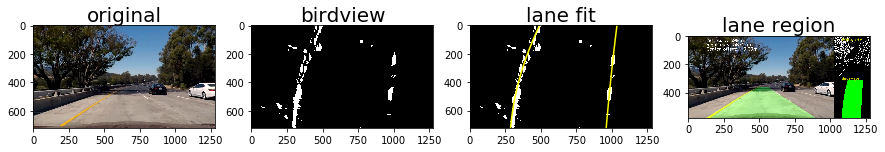

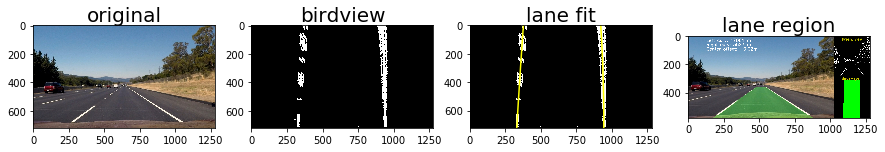

In [68]:
M, Minv = get_perspective_transform()
# Make a list of calibration images
images = glob.glob('./test_images/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = calibrate_image(img_rgb, mtx, dist)
    
    last, combined = pipeline(dst, M, Minv)
    
    #histogram = np.sum(last[last.shape[0]/2:,:], axis=0)
    
    left_fit, right_fit = lane_fit(last)
    print('left_fit = {0}, right_fit = {1}'.format(left_fit, right_fit))
    
    
    ploty = np.linspace(0, last.shape[0]-1, last.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    d = (right_fitx-left_fitx)*(3.7/700)
    print('mean = ', np.mean(d))
    print('var = ', np.var(d))
    

    left_curverad, right_curverad = get_curverad(left_fitx, right_fitx, ploty)
    diff = get_car_diff(left_fit, right_fit)
    print('left_curverad = {0:.0f}, right_curverad = {1:.0f}, diff = {2:.2f}'.format(left_curverad, right_curverad, diff))

    result, color_warp = draw_lane_region(last, left_fitx, right_fitx, ploty, Minv, dst)
    
    #Composition of images to final display
    img_out=np.zeros((576,1280,3), dtype=np.uint8)

    img_out[0:576,0:1024,:] =cv2.resize(result,(1024,576))
    #b) Threshold
    img_out[0:288,1024:1280, 0] =cv2.resize(combined*255,(256,288))
    img_out[0:288,1024:1280, 1] =cv2.resize(combined*255,(256,288))
    img_out[0:288,1024:1280, 2] =cv2.resize(combined*255,(256,288))
    #c)Birds eye view
    img_out[310:576,1024:1280,:] =cv2.resize(color_warp,(256,266))
    
    
    #Write curvature and center in image
    TextL = "Left curv: " + str(int(left_curverad)) + " m"
    TextR = "Right curv: " + str(int(right_curverad))+ " m"
    TextC = "Center offset: " + str(round( diff,2)) + "m"
    #TextAux = str(status_sanity) + ", d0: " + str(round(d0,2)) + ", d1: " + str(round(d1,2))
    fontScale=1
    thickness=2
    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX


    cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextC, (130,100), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    #cv2.putText(img_out, TextAux, (100,130), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    cv2.putText(img_out, "Thresh. view", (1070,30), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, "Birds-eye", (1080,305), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,8))
    ax1.imshow(img_rgb)
    ax1.set_title('original', fontsize=20)
    
    ax2.imshow(last, cmap='gray')
    ax2.set_title('birdview', fontsize=20)
    
    ax3.imshow(last, cmap='gray')
    ax3.plot(left_fitx, ploty, color='yellow')
    ax3.plot(right_fitx, ploty, color='yellow')
    ax3.set_xlim(0, 1280)
    ax3.set_ylim(720, 0)
    #ax3.imshow(last,cmap='gray')
    ax3.set_title('lane fit', fontsize=20)
    ax4.imshow(img_out)
    ax4.set_title('lane region', fontsize=20)
    
    


1 tracking every frame of vidio

2 Look-Ahead Filter

Once found the lane lines in one frame of video, so we are confident they are actually the lines we are looking for, don't need to search blindly in the next frame.  search within a window around the previous detection.

3 Reset:
If  sanity checks reveal that the lane lines detected are problematic for some reason, assume it was a bad or difficult frame of video, start searching from scratch using a histogram and sliding window to re-establish  measurement.


In [72]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        
 
   
    def sanity_check(self, fitx, fit, curverad):
       
        # Weight parameter
        w = 4
        # Sanity check for the lane
        if self.detected: # If lane is detected
            # If sanity check passes
            if abs(curverad / self.radius_of_curvature - 1) < .4:        
                self.detected = True
                self.current_fit = (self.current_fit * w + fit) / (w + 1)
                self.allx = fitx
                self.bestx = np.mean(fitx)            
                self.radius_of_curvature = curverad
            # If sanity check fails use the previous values
            else:
                self.detected = False
                fitx = self.allx
        else:
            # If lane was not detected and no curvature is defined
            if self.radius_of_curvature: 
                if abs(curverad / self.radius_of_curvature - 1) < .6:            
                    self.detected = True
                    self.current_fit = (self.current_fit * w + fit) / (w + 1)
                    self.allx = fitx
                    self.bestx = np.mean(fitx)            
                    self.radius_of_curvature = curverad
                else:
                    self.detected = False
                    fitx = self.allx      
        # If curvature was defined
            else:
                self.detected = True
                self.current_fit = (self.current_fit * w + fit) / (w + 1)
                self.allx = fitx
                self.bestx = np.mean(fitx)
                self.radius_of_curvature = curverad
        return fitx
 
    

In [70]:
def process_image(img):
    #img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = calibrate_image(img, mtx, dist)
    last, combined = pipeline(dst, M, Minv)
    
    left_fit, right_fit = lane_fit(last)   
    
    ploty = np.linspace(0, last.shape[0]-1, last.shape[0] ) 
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_curverad, right_curverad = get_curverad(left_fitx, right_fitx, ploty)
    diff = get_car_diff(left_fit, right_fit)
        
    left_fitx  = left_line.sanity_check(left_fitx, left_fit, left_curverad)
    right_fitx = right_line.sanity_check(right_fitx, right_fit, right_curverad)
        

    result, color_warp = draw_lane_region(last, left_fitx, right_fitx, ploty, Minv, dst)
    
    #Composition of images to final display
    img_out=np.zeros((576,1280,3), dtype=np.uint8)

    img_out[0:576,0:1024,:] =cv2.resize(result,(1024,576))
    #b) Threshold
    img_out[0:288,1024:1280, 0] =cv2.resize(combined*255,(256,288))
    img_out[0:288,1024:1280, 1] =cv2.resize(combined*255,(256,288))
    img_out[0:288,1024:1280, 2] =cv2.resize(combined*255,(256,288))
    #c)Birds eye view
    img_out[310:576,1024:1280,:] =cv2.resize(color_warp,(256,266))
    
    
    #Write curvature and center in image
    TextL = "Left curv: " + str(int(left_curverad)) + " m"
    TextR = "Right curv: " + str(int(right_curverad))+ " m"
    TextC = "Center offset: " + str(round( diff,2)) + "m"
    #TextAux = str(status_sanity) + ", d0: " + str(round(d0,2)) + ", d1: " + str(round(d1,2))
    fontScale=1
    thickness=2
    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX


    cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextC, (130,100), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    #cv2.putText(img_out, TextAux, (100,130), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    cv2.putText(img_out, "Thresh. view", (1070,30), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, "Birds-eye", (1080,305), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    return img_out

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

In [73]:
#Create video file pipeline
left_line = Line()
right_line = Line()
output = 'out_test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out_test_video.mp4
[MoviePy] Writing video out_test_video.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<03:18,  6.34it/s]

  0%|          | 2/1261 [00:00<03:20,  6.29it/s]

  0%|          | 3/1261 [00:00<03:21,  6.24it/s]

  0%|          | 4/1261 [00:00<03:15,  6.43it/s]

  0%|          | 6/1261 [00:00<03:01,  6.92it/s]

  1%|          | 7/1261 [00:00<02:57,  7.08it/s]

  1%|          | 8/1261 [00:01<02:45,  7.57it/s]

  1%|          | 9/1261 [00:01<02:33,  8.16it/s]

  1%|          | 11/1261 [00:01<02:29,  8.35it/s]

  1%|          | 12/1261 [00:01<02:24,  8.66it/s]

  1%|          | 13/1261 [00:01<02:33,  8.13it/s]

  1%|          | 14/1261 [00:01<02:34,  8.05it/s]

  1%|          | 15/1261 [00:01<02:42,  7.67it/s]

  1%|▏         | 16/1261 [00:02<02:47,  7.45it/s]

  1%|▏         | 17/1261 [00:02<02:45,  7.50it/s]

  1%|▏         | 18/1261 [00:02<02:46,  7.47it/s]

  2%|▏         | 19/1261 [00:02<02:54,  7.12it/s]

  2%|▏         | 20/1261 [00:02<02:43,  7.58it/s]

  2%|▏         | 21/1261 [00:02<02:49,  7.33it

[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test_video.mp4 

CPU times: user 17min 50s, sys: 37.1 s, total: 18min 27s
Wall time: 2min 59s


Pipeline (video)

In [74]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

Discussion

In this project, I searched lane lanes from the image. The procesure is as follows. First, I calculated camera matrics and distortion coefficients to undistort image. Then I use several techniques to find lane lines. Firstly, I select R color space , then transform the color space from RGB to HSV to select V channel. Then I used LS channel of HLS to get sobel operation to detect edges. Finally I put it together to find the lane lines.
   I failed for challenge vidio. and I think when the lane line disappear, or when the road has very strong shadow. the algrothm isn't good enough. so I need more robust algorithm.
   firstly in the process of lane fit, we can try some machine learning algorithm ,such as RANSAC. 
   secondly I want to apply is to use deep learning to solve this problem. use cnn to regress six fit parameter for lane line? I save the data but  have no time to test the deeplearning.